# Train Attention Model (Memory-Efficient for 8GB GPU)

This notebook trains a **memory-optimized** attention model.

**Optimizations for 8GB GPU**:
- Smaller embedding dimension (128 vs 256)
- Smaller hidden dimension (256 vs 512)
- Fewer LSTM layers (1 vs 2)
- Moderate batch size (12 vs 32)

**Model**: CNN + BiLSTM encoder with Bahdanau attention + LSTM decoder

**Estimated time**: 3-5 hours (35 epochs on GPU)

In [1]:
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

import sys
from pathlib import Path

project_root = Path('..').absolute()
sys.path.insert(0, str(project_root))

import torch
torch.cuda.empty_cache()
import gc
gc.collect()

import json
from src.models import create_model
from src.dataset import create_dataloaders
from src.trainer import ModelTrainer
from src.utils import load_vocab, set_seed, get_device, count_parameters, make_json_serializable

print("✓ Imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✓ Imports successful!
PyTorch version: 2.7.1+cu118
CUDA available: True


In [2]:
set_seed(42)
device = get_device()

if torch.cuda.is_available():
    total_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    free_memory = torch.cuda.mem_get_info()[0] / 1024**3
    print(f"\nGPU: {torch.cuda.get_device_name(0)}")
    print(f"Total GPU memory: {total_memory:.2f} GB")
    print(f"Free GPU memory: {free_memory:.2f} GB")

Random seed set to 42
Using device: cuda (NVIDIA GeForce RTX 3070 Ti Laptop GPU)

GPU: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Total GPU memory: 7.66 GB
Free GPU memory: 7.43 GB


In [3]:
vocab = load_vocab('../vocab.json')
print(f"Vocabulary size: {len(vocab)}")

Vocabulary loaded from ../vocab.json (size: 5986)
Vocabulary size: 5986


In [ ]:
print("Creating dataloaders...")
print("Using batch_size=20 (attention model uses more memory)\n")

train_loader, val_loader, eval_dataset = create_dataloaders(
    train_captions='../data/train_captions.json',
    val_captions='../data/val_captions.json',
    eval_captions='../data/eval_captions.json',
    train_features_dir='../features/mel/',
    val_features_dir='../features/mel/',
    eval_features_dir='../features/mel_eval/',
    vocab=vocab,
    batch_size=20,     # Smaller than baseline (attention uses more memory)
    num_workers=8
)

print(f"\n✓ Dataloaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Eval samples: {len(eval_dataset)}")

Creating dataloaders...
Using batch_size=12 (attention model uses more memory)

Loaded 3839 samples from ../data/train_captions.json
Loaded 1045 samples from ../data/val_captions.json
Loaded 1045 samples for evaluation

✓ Dataloaders created:
  Train batches: 191
  Val batches: 53
  Eval samples: 1045


## Create Memory-Efficient Attention Model

In [5]:
print("Creating MEMORY-EFFICIENT attention model...\n")
print("Model configuration (optimized for 8GB GPU):")
print("  - Embedding dimension: 128 (reduced from 256)")
print("  - Hidden dimension: 256 (reduced from 512)")
print("  - LSTM layers: 1 (reduced from 2)")
print("\nAttention mechanism adds ~20% more memory than baseline\n")

model = create_model(
    'attention', 
    vocab_size=len(vocab),
    embed_dim=128,
    hidden_dim=256,
    num_layers=1
)

print("\nModel architecture:")
print(model)

print("\nParameter count:")
total_params, trainable_params = count_parameters(model)

model_memory = total_params * 4 / (1024**3)
print(f"\nEstimated model memory: {model_memory:.2f} GB")

print("\nMoving model to GPU...")
model = model.to(device)

if torch.cuda.is_available():
    allocated = torch.cuda.memory_allocated() / 1024**3
    free = torch.cuda.mem_get_info()[0] / 1024**3
    
    print(f"\nGPU Memory Status:")
    print(f"  Allocated: {allocated:.2f} GB")
    print(f"  Free: {free:.2f} GB")
    
    if free > 3:
        print(f"\n✓ Model fits comfortably in GPU memory!")
    else:
        print(f"\n⚠️ Warning: Only {free:.2f} GB free (may be tight during training)")

Creating MEMORY-EFFICIENT attention model...

Model configuration (optimized for 8GB GPU):
  - Embedding dimension: 128 (reduced from 256)
  - Hidden dimension: 256 (reduced from 512)
  - LSTM layers: 1 (reduced from 2)

Attention mechanism adds ~20% more memory than baseline


Model architecture:
AttentionModel(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1,

In [6]:
trainer = ModelTrainer(
    model=model,
    vocab=vocab,
    device=device,
    model_name='attention_small'
)

print("✓ Trainer ready!")

✓ Trainer ready!


## Train Model

**Training time**: 3-5 hours on GPU (35 epochs)

The attention model should outperform the baseline by focusing on relevant audio segments.

In [7]:
print("="*80)
print("ATTENTION MODEL TRAINING (Memory-Efficient)")
print("="*80)
print("\nTraining attention model optimized for 8GB GPU")
print("Expected training time: 3-5 hours\n")

history = trainer.fit(
    train_loader=train_loader,
    val_loader=val_loader,
    eval_dataset=eval_dataset,
    num_epochs=35,
    learning_rate=3e-4,
    weight_decay=1e-4,
    patience=5,
    label_smoothing=0.1,
    save_dir='../checkpoints'
)

print("\n✓ Training complete!")

ATTENTION MODEL TRAINING (Memory-Efficient)

Training attention model optimized for 8GB GPU
Expected training time: 3-5 hours


Epoch 1/35


Validating: 100%|██████████| 53/53 [00:04<00:00, 11.23it/s]



Train Loss: 6.3873
Val Loss:   6.0169
LR:         0.000300
Model saved to ../checkpoints/best_attention_small.pth
✓ New best model saved!

Epoch 2/35


Validating: 100%|██████████| 53/53 [00:04<00:00, 11.06it/s]



Train Loss: 5.8109
Val Loss:   5.7456
LR:         0.000300
Model saved to ../checkpoints/best_attention_small.pth
✓ New best model saved!

Epoch 3/35


Validating: 100%|██████████| 53/53 [00:04<00:00, 11.30it/s]



Train Loss: 5.5721
Val Loss:   5.5541
LR:         0.000300
Model saved to ../checkpoints/best_attention_small.pth
✓ New best model saved!

Epoch 4/35


Validating: 100%|██████████| 53/53 [00:04<00:00, 11.31it/s]



Train Loss: 5.4303
Val Loss:   5.4468
LR:         0.000300
Model saved to ../checkpoints/best_attention_small.pth
✓ New best model saved!

Epoch 5/35


Validating: 100%|██████████| 53/53 [00:04<00:00, 11.01it/s]



Train Loss: 5.3053
Val Loss:   5.3289
LR:         0.000300

Sample Generations:
------------------------------------------------------------
1. Ground Truth: A machine whines and squeals while rhythmically punching or stamping.
   Generated:    a person is walking on a hard and then a person is running

2. Ground Truth: A radio dispatcher and an officer are communicating over the radio.
   Generated:    a person is walking on a hard and then a man is being in the background.

3. Ground Truth: A radio tuner has been positioned in between radio stations to generate horrific static.
   Generated:    a person is running and a steady is running

Model saved to ../checkpoints/best_attention_small.pth
✓ New best model saved!

Epoch 6/35


Validating: 100%|██████████| 53/53 [00:04<00:00, 11.80it/s]



Train Loss: 5.2088
Val Loss:   5.2895
LR:         0.000300
Model saved to ../checkpoints/best_attention_small.pth
✓ New best model saved!

Epoch 7/35


Validating: 100%|██████████| 53/53 [00:04<00:00, 11.11it/s]



Train Loss: 5.1551
Val Loss:   5.2053
LR:         0.000300
Model saved to ../checkpoints/best_attention_small.pth
✓ New best model saved!

Epoch 8/35


Validating: 100%|██████████| 53/53 [00:04<00:00, 11.13it/s]



Train Loss: 5.0722
Val Loss:   5.1604
LR:         0.000300
Model saved to ../checkpoints/best_attention_small.pth
✓ New best model saved!

Epoch 9/35


Validating: 100%|██████████| 53/53 [00:04<00:00, 11.56it/s]



Train Loss: 4.9917
Val Loss:   5.1148
LR:         0.000300
Model saved to ../checkpoints/best_attention_small.pth
✓ New best model saved!

Epoch 10/35


Validating: 100%|██████████| 53/53 [00:04<00:00, 11.38it/s]



Train Loss: 4.9423
Val Loss:   5.0460
LR:         0.000300

Sample Generations:
------------------------------------------------------------
1. Ground Truth: A machine whines and squeals while rhythmically punching or stamping.
   Generated:    a person is walking through a container and then a person is walking on a drain.

2. Ground Truth: A radio dispatcher and an officer are communicating over the radio.
   Generated:    a person is walking through a hard surface and then a man speaks

3. Ground Truth: A radio tuner has been positioned in between radio stations to generate horrific static.
   Generated:    a person is walking on a roof and then a steady pace.

Model saved to ../checkpoints/best_attention_small.pth
✓ New best model saved!

Epoch 11/35


Validating: 100%|██████████| 53/53 [00:04<00:00, 11.20it/s]



Train Loss: 4.8907
Val Loss:   5.0123
LR:         0.000300
Model saved to ../checkpoints/best_attention_small.pth
✓ New best model saved!

Epoch 12/35


Validating: 100%|██████████| 53/53 [00:04<00:00, 11.09it/s]



Train Loss: 4.8427
Val Loss:   5.0360
LR:         0.000300

Epoch 13/35


Validating: 100%|██████████| 53/53 [00:04<00:00, 11.03it/s]



Train Loss: 4.8012
Val Loss:   4.9494
LR:         0.000300
Model saved to ../checkpoints/best_attention_small.pth
✓ New best model saved!

Epoch 14/35


Validating: 100%|██████████| 53/53 [00:04<00:00, 11.03it/s]



Train Loss: 4.7496
Val Loss:   4.8944
LR:         0.000300
Model saved to ../checkpoints/best_attention_small.pth
✓ New best model saved!

Epoch 15/35


Validating: 100%|██████████| 53/53 [00:04<00:00, 10.87it/s]



Train Loss: 4.7176
Val Loss:   4.9345
LR:         0.000300

Sample Generations:
------------------------------------------------------------
1. Ground Truth: A machine whines and squeals while rhythmically punching or stamping.
   Generated:    a person is walking through a metal surface and then it is turned off.

2. Ground Truth: A radio dispatcher and an officer are communicating over the radio.
   Generated:    a man is speaking while a man speaks and then a man speaks

3. Ground Truth: A radio tuner has been positioned in between radio stations to generate horrific static.
   Generated:    a machine is running and then it is turned off.


Epoch 16/35


Validating: 100%|██████████| 53/53 [00:04<00:00, 11.00it/s]



Train Loss: 4.6827
Val Loss:   4.8756
LR:         0.000300
Model saved to ../checkpoints/best_attention_small.pth
✓ New best model saved!

Epoch 17/35


Validating: 100%|██████████| 53/53 [00:04<00:00, 11.43it/s]



Train Loss: 4.6328
Val Loss:   4.8979
LR:         0.000300

Epoch 18/35


Validating: 100%|██████████| 53/53 [00:04<00:00, 11.37it/s]



Train Loss: 4.6142
Val Loss:   4.8511
LR:         0.000300
Model saved to ../checkpoints/best_attention_small.pth
✓ New best model saved!

Epoch 19/35


Validating: 100%|██████████| 53/53 [00:05<00:00, 10.41it/s]



Train Loss: 4.5727
Val Loss:   4.8431
LR:         0.000300
Model saved to ../checkpoints/best_attention_small.pth
✓ New best model saved!

Epoch 20/35


Validating: 100%|██████████| 53/53 [00:05<00:00, 10.56it/s]



Train Loss: 4.5505
Val Loss:   4.8050
LR:         0.000300

Sample Generations:
------------------------------------------------------------
1. Ground Truth: A machine whines and squeals while rhythmically punching or stamping.
   Generated:    a person is walking on a gravel and then a car drives by.

2. Ground Truth: A radio dispatcher and an officer are communicating over the radio.
   Generated:    a group of people are talking and a man is speaking in the background.

3. Ground Truth: A radio tuner has been positioned in between radio stations to generate horrific static.
   Generated:    a heavy rain is falling down and a hard object is running.

Model saved to ../checkpoints/best_attention_small.pth
✓ New best model saved!

Epoch 21/35


Validating: 100%|██████████| 53/53 [00:04<00:00, 10.82it/s]



Train Loss: 4.5318
Val Loss:   4.7993
LR:         0.000300
Model saved to ../checkpoints/best_attention_small.pth
✓ New best model saved!

Epoch 22/35


Validating: 100%|██████████| 53/53 [00:04<00:00, 11.08it/s]



Train Loss: 4.4878
Val Loss:   4.7844
LR:         0.000300
Model saved to ../checkpoints/best_attention_small.pth
✓ New best model saved!

Epoch 23/35


Validating: 100%|██████████| 53/53 [00:04<00:00, 11.64it/s]



Train Loss: 4.4569
Val Loss:   4.7588
LR:         0.000300
Model saved to ../checkpoints/best_attention_small.pth
✓ New best model saved!

Epoch 24/35


Validating: 100%|██████████| 53/53 [00:04<00:00, 11.11it/s]



Train Loss: 4.4283
Val Loss:   4.7526
LR:         0.000300
Model saved to ../checkpoints/best_attention_small.pth
✓ New best model saved!

Epoch 25/35


Validating: 100%|██████████| 53/53 [00:04<00:00, 11.12it/s]



Train Loss: 4.4164
Val Loss:   4.7320
LR:         0.000300

Sample Generations:
------------------------------------------------------------
1. Ground Truth: A machine whines and squeals while rhythmically punching or stamping.
   Generated:    a machine is running and then a door is being used

2. Ground Truth: A radio dispatcher and an officer are communicating over the radio.
   Generated:    a crowd of people are talking and laughing in the background.

3. Ground Truth: A radio tuner has been positioned in between radio stations to generate horrific static.
   Generated:    a heavy rain is falling down on a roof

Model saved to ../checkpoints/best_attention_small.pth
✓ New best model saved!

Epoch 26/35


Validating: 100%|██████████| 53/53 [00:04<00:00, 11.31it/s]



Train Loss: 4.3812
Val Loss:   4.7508
LR:         0.000300

Epoch 27/35


Validating: 100%|██████████| 53/53 [00:04<00:00, 11.03it/s]



Train Loss: 4.3590
Val Loss:   4.7148
LR:         0.000300
Model saved to ../checkpoints/best_attention_small.pth
✓ New best model saved!

Epoch 28/35


Validating: 100%|██████████| 53/53 [00:04<00:00, 11.04it/s]



Train Loss: 4.3242
Val Loss:   4.7114
LR:         0.000300
Model saved to ../checkpoints/best_attention_small.pth
✓ New best model saved!

Epoch 29/35


Validating: 100%|██████████| 53/53 [00:04<00:00, 11.22it/s]



Train Loss: 4.2998
Val Loss:   4.7083
LR:         0.000300
Model saved to ../checkpoints/best_attention_small.pth
✓ New best model saved!

Epoch 30/35


Validating: 100%|██████████| 53/53 [00:04<00:00, 11.07it/s]



Train Loss: 4.3024
Val Loss:   4.6598
LR:         0.000300

Sample Generations:
------------------------------------------------------------
1. Ground Truth: A machine whines and squeals while rhythmically punching or stamping.
   Generated:    a machine is running and then a machine is running in the background.

2. Ground Truth: A radio dispatcher and an officer are communicating over the radio.
   Generated:    a group of people are talking and a man is speaking in the background.

3. Ground Truth: A radio tuner has been positioned in between radio stations to generate horrific static.
   Generated:    a machine is running and a machine is running in the background.

Model saved to ../checkpoints/best_attention_small.pth
✓ New best model saved!

Epoch 31/35


Validating: 100%|██████████| 53/53 [00:04<00:00, 11.12it/s]



Train Loss: 4.2515
Val Loss:   4.6754
LR:         0.000300

Epoch 32/35


Validating: 100%|██████████| 53/53 [00:04<00:00, 11.05it/s]



Train Loss: 4.2508
Val Loss:   4.6629
LR:         0.000300

Epoch 33/35


Validating: 100%|██████████| 53/53 [00:04<00:00, 11.07it/s]



⚡ Learning rate reduced: 0.000300 → 0.000150

Train Loss: 4.2051
Val Loss:   4.6753
LR:         0.000150

Epoch 34/35


Validating: 100%|██████████| 53/53 [00:04<00:00, 10.87it/s]



Train Loss: 4.1624
Val Loss:   4.6414
LR:         0.000150
Model saved to ../checkpoints/best_attention_small.pth
✓ New best model saved!

Epoch 35/35


Validating: 100%|██████████| 53/53 [00:04<00:00, 11.07it/s]


Train Loss: 4.1647
Val Loss:   4.6743
LR:         0.000150

Sample Generations:
------------------------------------------------------------
1. Ground Truth: A machine whines and squeals while rhythmically punching or stamping.
   Generated:    a machine is running at a constant speed and then it is turned off.

2. Ground Truth: A radio dispatcher and an officer are communicating over the radio.
   Generated:    a group of people are talking and a dog is barking

3. Ground Truth: A radio tuner has been positioned in between radio stations to generate horrific static.
   Generated:    a machine is running at a constant rate and volume.


Training Complete!
Best Validation Loss: 4.6414

✓ Training complete!


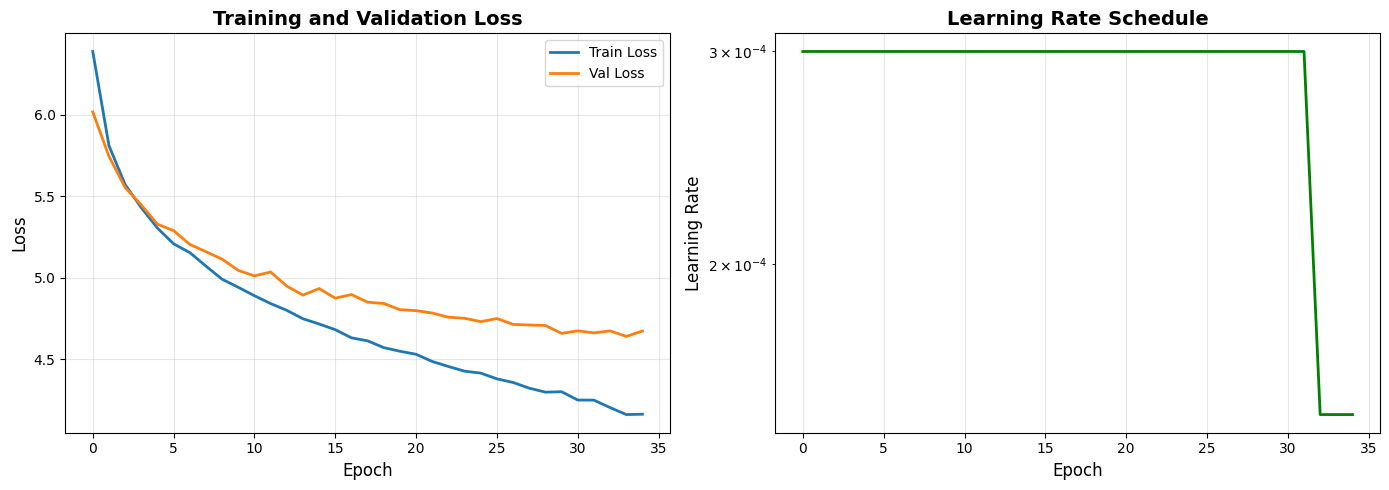

✓ History saved


In [8]:
from src.utils import plot_training_history
import matplotlib.pyplot as plt

plot_training_history(history)
plt.show()

with open('../results/attention_small_history.json', 'w') as f:
    json.dump(history, f, indent=2)
print("✓ History saved")

In [ ]:
from src.evaluation import evaluate_model

results, captions, refs = evaluate_model(
    trainer.model,
    eval_dataset,
    vocab,
    device=device,
    num_samples=100
)


serializable_results = make_json_serializable(results)
with open('../results/attention_small_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("✓ Results saved")

In [ ]:
from src.evaluation import get_sample_predictions, print_sample_predictions

samples = get_sample_predictions(trainer.model, eval_dataset, vocab, device=device, num_samples=10)
print_sample_predictions(samples, num_to_print=10)

## Summary

In [ ]:
print("\n" + "="*80)
print("TRAINING SUMMARY")
print("="*80)
print(f"\nModel: Attention (Memory-Efficient with Bahdanau Attention)")
print(f"Best validation loss: {min(history['val_loss']):.4f}")
print(f"\nEvaluation metrics:")
print(f"  - Repetition rate: {results['avg_repetition_rate']:.4f}")
print(f"  - Vocabulary diversity: {results['vocabulary_diversity']:.4f}")
print(f"  - Mean caption length: {results['mean_caption_length']:.2f} words")
print(f"\nFiles saved:")
print(f"  ✓ ../checkpoints/best_attention_small.pth")
print(f"  ✓ ../results/attention_small_history.json")
print(f"  ✓ ../results/attention_small_results.json")
print("\n" + "="*80)
print("Next: Train transformer model with 04_train_transformer_memory_efficient.ipynb")
print("="*80)